In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import mpld3
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.tools import FigureFactory as FF
tls.set_credentials_file(username='mmainzer', api_key='1fhs3tcl9m')

from IPython.display import HTML

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
import os
from scipy.cluster.hierarchy import fcluster
import scipy.stats as stats

In [2]:
df = pd.read_csv('../../assets/capstone-assets/CCRPI/master.csv')

In [3]:
df.locClass.fillna(21, inplace=True)

In [4]:
df.pctGiftd.fillna(0, inplace=True)

In [5]:
#Normalize the feature columns so the x axes in our subplots are all on the same scale.
cols_to_norm = ['stdTchRatio', 'expPerStudent','salBenSum','freeLnch','reducedLnch','pctMobile','pctAbs5orLess',
                'pctAbsSix-Fiftn', 'expPerStudent','salBenSum','freeLnch','reducedLnch','pctMobile','pctAbs5orLess',
                'pctAbsSix-Fiftn', 'pctOverFiftn','pctSnapTanfHmls', 'pctAsian','pctNative','pctBlck','pctHisp',
                'pctMulti','pctWhite','pctMigrant','pctSPED','pctESOL','pctAltProg','pctGiftd']

df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [6]:
df2 = df[['ccrpi', 'sysID','sysName','schoolID','schoolName', 'grd', 'locClass','titleI','chrtr','stdTchRatio',
          'expPerStudent','salBenSum','freeLnch','reducedLnch','pctMobile','pctAbs5orLess','pctAbsSix-Fiftn',
          'pctOverFiftn','pctSnapTanfHmls', 'pctAsian','pctNative','pctBlck','pctHisp','pctMulti','pctWhite',
         'pctMigrant','pctSPED','pctESOL','pctAltProg','pctGiftd']]

In [7]:
df2['titleI'] = df2['titleI'].map({'No': 0, 'Yes': 1} )
df2['chrtr'] = df2['chrtr'].map({'No': 0, 'Yes': 1} )

/Users/jb3/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jb3/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [8]:
#keep the list of feature names because once we run pca and convert that to a correlation table, we'll want
#these instead of 0, 1, 2, etc.
features = df2.iloc[:,7:]

In [9]:
x = df2.ix[:,7:].values
y = df2.ix[:,0].values
xStandardized = pd.DataFrame(StandardScaler().fit_transform(x))

In [10]:
cov_mat = np.cov(xStandardized.T)

In [11]:
#Decompose the covariance matrix to find the eigenvalues
eigenValues, eigenVectors = np.linalg.eig(cov_mat)

In [12]:
#Now sort the eigenpairs from highest to lowest.
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]

In [13]:
#Display the value for each vector and sort. 
eigenPairs.reverse()
for i in eigenPairs:
    print (i[0])

0.000415462571355
1.49841779789e-05
0.435202515341
0.393058963735
0.351091828108
0.466103831201
0.308415495307
0.565910296455
0.143805003791
0.106034253397
0.593259318302
0.752130828459
0.776667533609
0.90263732695
0.978328644569
1.06413573427
1.16992609798
1.23000917949
1.60151188026
1.71222201542
2.30119189361
2.98519771391
4.17495024053


In [14]:
eigenValSum = sum(eigenValues)
#calculate the degree to which each eigenPair contributes to the variance
varExplained = [(i / eigenValSum)*100 for i in sorted(eigenValues, reverse=True)]
cumVarExplained = np.cumsum(varExplained)

In [15]:
# trace1 = Bar(x=['PC %s' %i for i in range(1,24)], y=varExplained, showlegend=False)

# trace2 = Scatter(x=['PC %s' %i for i in range(1,24)], y=cumVarExplained, name='Cumulative Explained Variance')

# data = Data([trace1, trace2])

# layout=Layout (yaxis=YAxis(title='Percent of Explained Variance'), title='Explained Variance by Principal Component')

# fig = Figure(data=data, layout=layout)
# py.iplot(fig)

tls.embed("https://plot.ly/~mmainzer/141/explained-variance-by-principal-component/")

/Users/jb3/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning:

DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.

/Users/jb3/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning:

PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.



In [16]:
pca = PCA(n_components=12)
pcaDf = pd.DataFrame(pca.fit_transform(xStandardized), columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6',
                                                               'PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'])

In [17]:
#We'll want to visualize our data after PCA, but see where each school lies within the subspace, so I created
#a new dataframe that gives our principal components and where each school lies along that component.

pcaDf['ccrpi'] = df2['ccrpi']
pcaDf['sysID'] = df2['sysID']
pcaDf['sysName'] = df2['sysName']
pcaDf['schoolID'] = df2['schoolID']
pcaDf['schoolName'] = df2['schoolName']
pcaDf['grd'] = df2['grd']

In [18]:
pcaFeatureCorr = pd.DataFrame(pca.components_,columns=features.columns,index = ['PC-1','PC-2','PC-3','PC-4',
                                                                                'PC-5','PC-6','PC-7','PC-8',
                                                                                'PC-9','PC-10','PC-11','PC-12'])

In [19]:
pd.set_option('display.max_columns', None)
pcaFeatureCorr

,titleI,chrtr,stdTchRatio,expPerStudent,salBenSum,freeLnch,reducedLnch,pctMobile,pctAbs5orLess,pctAbsSix-Fiftn,pctOverFiftn,pctSnapTanfHmls,pctAsian,pctNative,pctBlck,pctHisp,pctMulti,pctWhite,pctMigrant,pctSPED,pctESOL,pctAltProg,pctGiftd
PC-1,0.337870,-0.025304,-0.002631,0.090896,-0.120342,0.218998,-0.151607,0.255187,-0.127127,0.013743,0.198879,0.449915,-0.247407,-0.041382,0.353957,0.039426,-0.181512,-0.323833,0.068403,0.036552,0.064569,0.078468,-0.352338
PC-2,-0.013538,0.084375,0.083045,-0.130531,0.362260,0.185710,0.066874,0.051858,0.421411,-0.389610,-0.262012,-0.008938,0.209264,0.033214,0.151272,0.309451,-0.004001,-0.346122,-0.013700,-0.151167,0.301633,0.011582,0.016040
PC-3,-0.103086,0.156366,0.202890,0.152481,-0.099020,-0.242195,-0.213543,0.117504,0.287540,-0.323161,-0.112842,0.068071,0.001520,0.020015,0.265577,-0.465676,0.019767,-0.042288,-0.224584,-0.093924,-0.431423,0.176260,0.041689
PC-4,-0.179541,-0.102805,-0.028514,-0.208887,0.300832,0.329728,0.402558,0.064209,-0.230080,-0.007950,0.397710,-0.075741,0.134307,-0.108650,0.196813,-0.155224,0.001818,-0.147586,-0.331106,0.069478,-0.254559,0.141840,0.128875
PC-5,-0.115228,0.057712,0.513416,-0.037203,-0.053934,-0.024908,0.017457,0.240841,-0.083737,-0.075039,0.227816,-0.098198,-0.031521,0.120882,-0.227571,0.176717,-0.119742,0.156203,0.173190,-0.103370,0.123677,0.623190,-0.026158
PC-6,0.150156,-0.473814,0.214487,-0.121034,-0.042374,-0.009323,0.196798,0.190071,0.200336,-0.102783,-0.219704,0.034914,-0.187143,-0.122633,-0.084805,0.004921,0.375187,0.095527,-0.078730,0.532449,-0.030784,0.046262,-0.124168
PC-7,0.104265,-0.215846,0.274469,-0.496690,-0.233041,0.175292,0.023538,-0.469008,0.077885,-0.029650,-0.097118,0.044328,-0.206327,-0.248923,0.050378,-0.090000,-0.208006,0.044704,0.069845,-0.347564,-0.093774,-0.026214,0.031766
PC-8,-0.077004,-0.354787,0.102857,-0.066097,0.201867,-0.282980,-0.426982,0.163397,-0.130497,0.233636,-0.048857,0.023627,0.390989,-0.501310,0.044940,-0.016785,-0.107893,-0.100112,-0.040602,-0.036686,0.117637,0.043360,0.044563
PC-9,0.021835,0.207914,-0.010711,0.411091,-0.074808,0.127159,0.186042,-0.040265,0.123141,-0.196403,0.018177,-0.030867,-0.099374,-0.641866,-0.104647,0.098741,-0.359393,0.104526,0.029092,0.227815,0.000887,0.004294,0.196830
PC-10,-0.078152,-0.401582,-0.147741,-0.013020,0.017151,0.059299,-0.077698,0.007047,0.099086,-0.218394,0.084653,0.054032,0.167111,0.332803,0.033650,-0.107489,-0.439940,0.013130,0.471456,0.276013,-0.145272,-0.035108,0.259328


In [20]:
#why choose these features?
f = features[['titleI', 'pctAbsSix-Fiftn', 'pctSnapTanfHmls',
                'pctBlck','pctAsian','pctGiftd', 'pctMobile']]

In [21]:
X = f.as_matrix(columns=None)

For 2 clusters the average Silhouette Score is : 0.61130548805


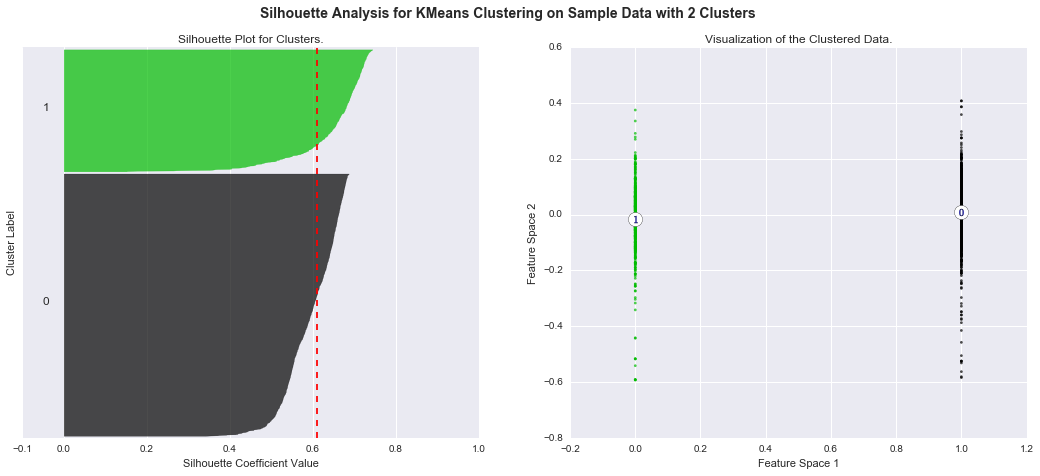

For 3 clusters the average Silhouette Score is : 0.528567488828


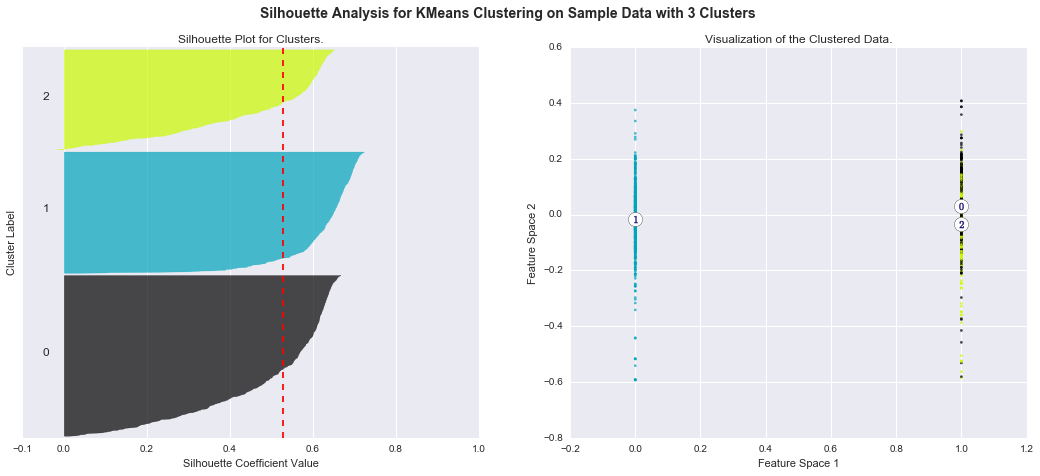

For 4 clusters the average Silhouette Score is : 0.442360373567


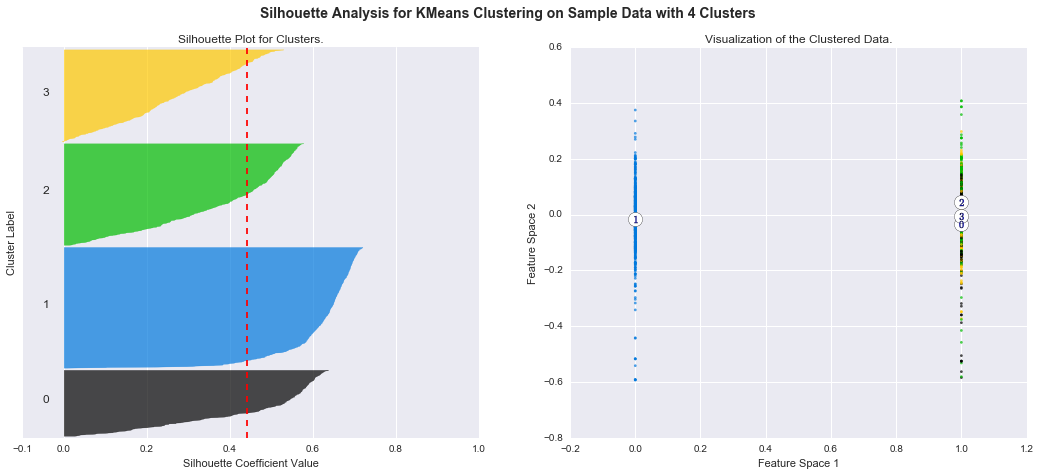

For 5 clusters the average Silhouette Score is : 0.354811055239


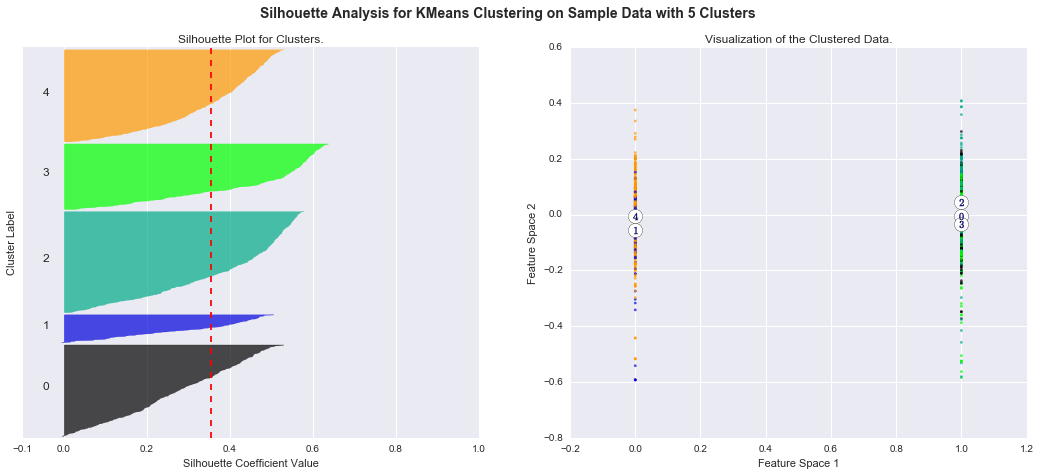

For 6 clusters the average Silhouette Score is : 0.342569262311


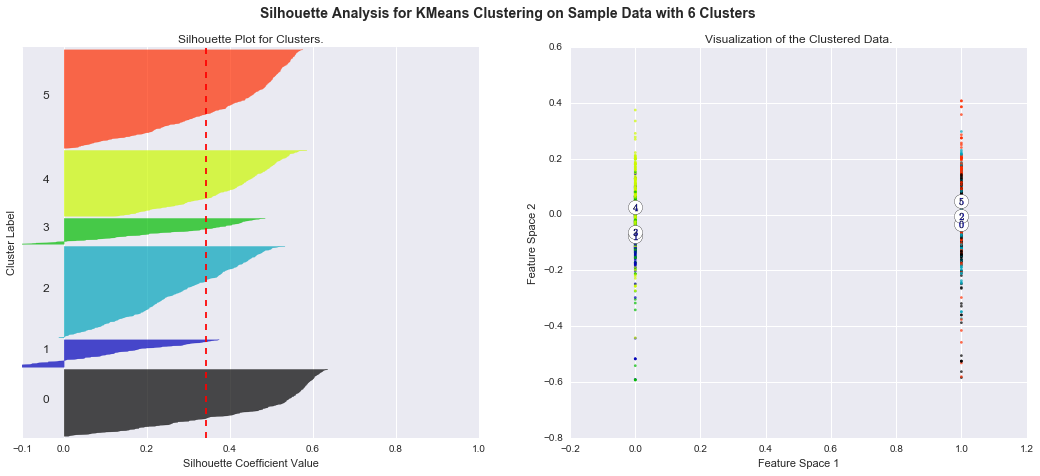

In [22]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print "For", n_clusters, "clusters", "the average Silhouette Score is :", silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for Clusters.")
    ax1.set_xlabel("Silhouette Coefficient Value")
    ax1.set_ylabel("Cluster Label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space 1")
    ax2.set_ylabel("Feature Space 2")

    plt.suptitle(("Silhouette Analysis for KMeans Clustering on Sample Data "
                  "with %d Clusters" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [23]:
# the results from above are garbage, as I suspected since we have a mix of categorical and numerical data

In [24]:
Z = linkage(X, 'ward')

In [25]:
# the cophenetic correlation coefficient is a measure of how faithfully the clustering tree represents the
# dissimilarities among the samples. With a value of 0.91, we know that there is a pretty clean separation between
# clusters, and this confirms that using this features to determine our clusters. This is a far more accurate
# than the silhouette score when running our features through kMeans clustering. All that remains is to choose
# the appropriate number of clusters. We have to look at the tree to do this.

c, coph_dists = cophenet(Z, pdist(X))
c

0.90961327135108183

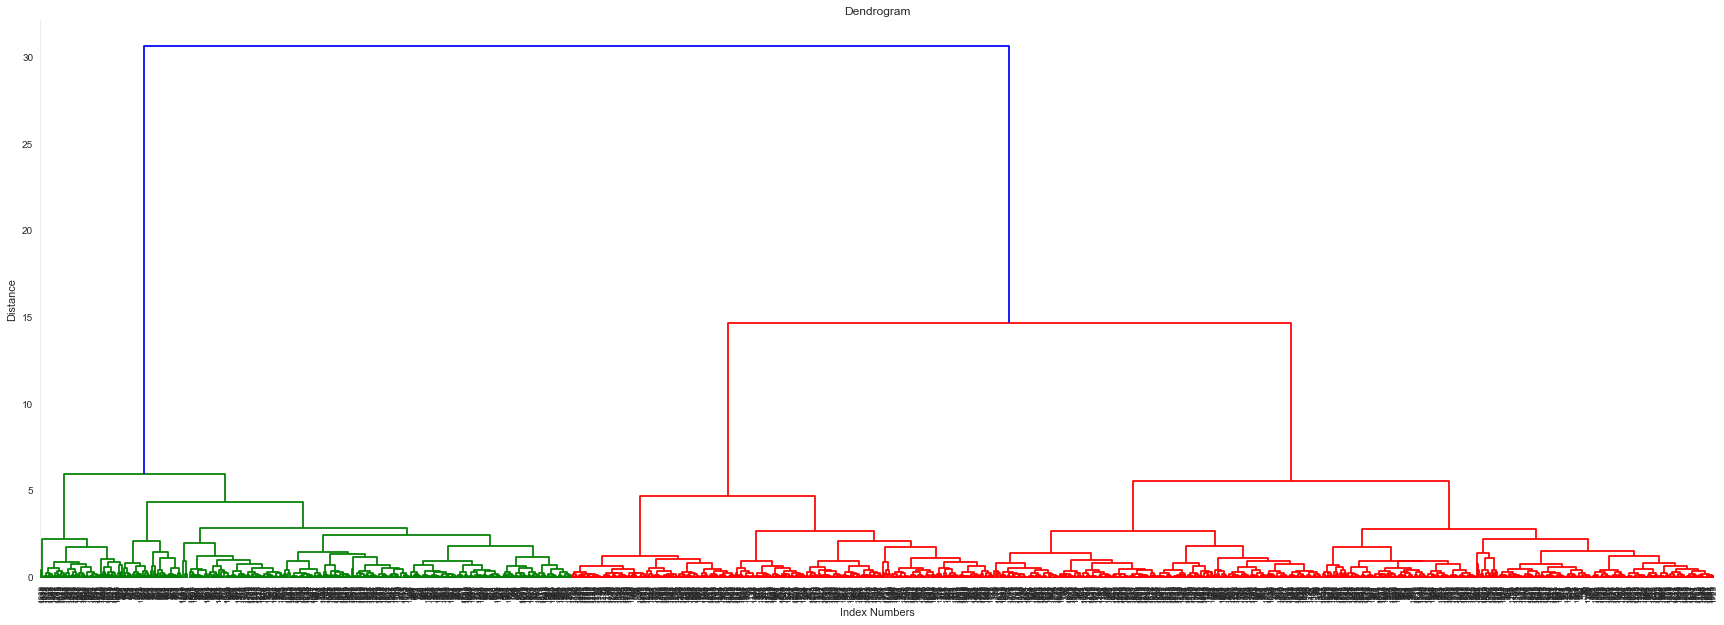

In [26]:
# this is way too large, and it doesn't make any sense, so instead we can look at a truncated version

plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

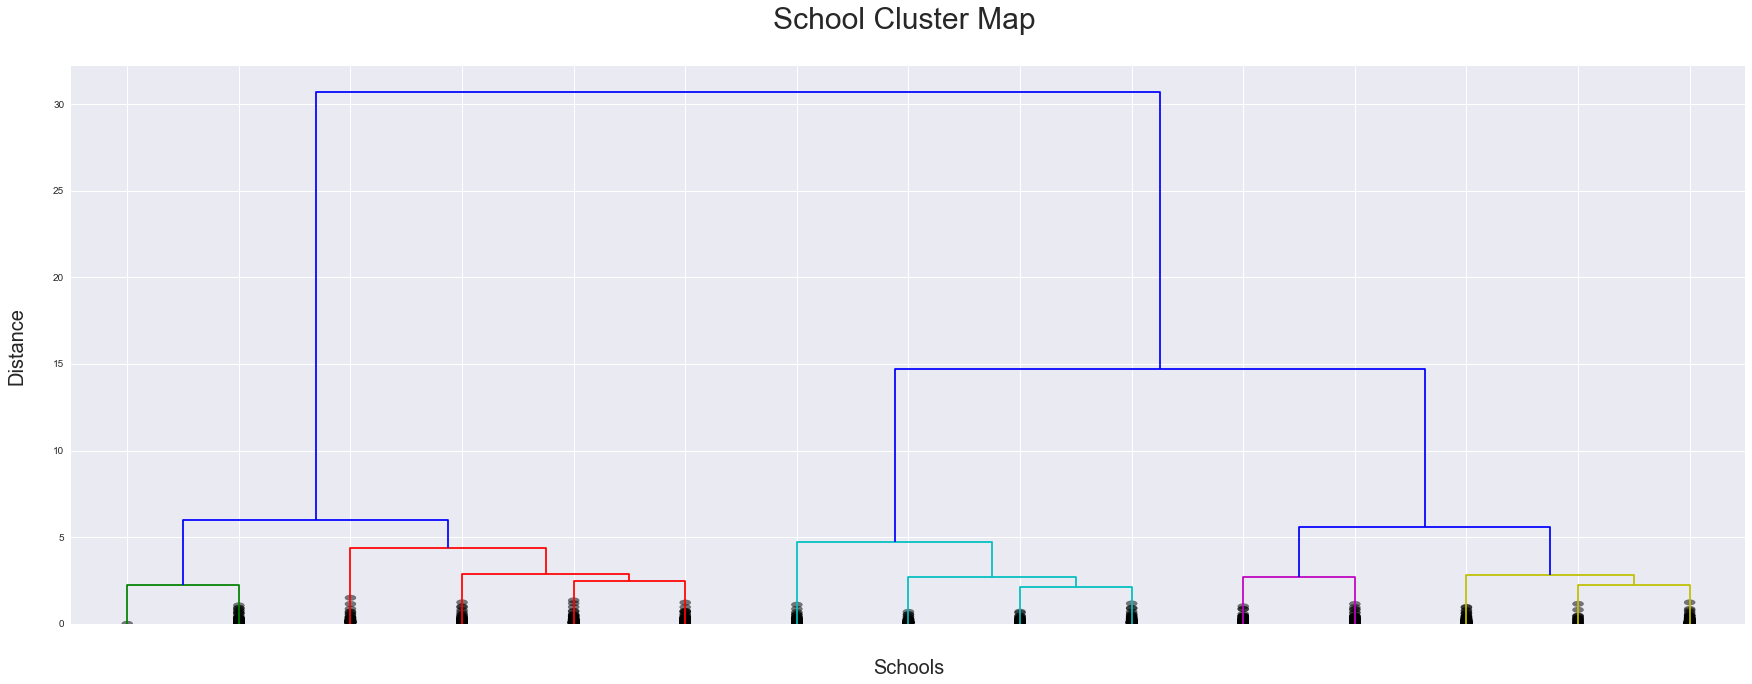

In [27]:
# a truncated version is easier to visualize

plt.figure(figsize=(30, 10))
plt.title('School Cluster Map \n', fontsize=30)
plt.xlabel('\nSchools', fontsize=20)
plt.ylabel('Distance\n', fontsize=20)
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=5
)
plt.show()

In [28]:
# We want to choose a horizontal distance where a series of splits happen very close to one another.
# We could split at 6, which would give us 3 clusters. However, each of those 3 clusters immediately split 
# into more clusters, which tells me there's a whole lot of variance within those 3 larger clusters.
# Instead, by setting a distance slightly below that, at 5, lets us capture those 5 more compact groups
# beneath them. Also, it lets us isolate a small group of seeming outliers, at cluster 1, in green.
# This may be schools like those outliers in the scatterplot above for the percentage of students entering
# or exiting at some point during the school year.

max_d = 5
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 5, 5, ..., 5, 1, 5], dtype=int32)

In [29]:
unique, counts = np.unique(clusters, return_counts=True)

print np.asarray((unique, counts)).T

[[  1  93]
 [  2 505]
 [  3 474]
 [  4 369]
 [  5 442]]


In [30]:
ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X)

label = ward.labels_

# using the ward distance I repeat the same process with sklearn's algorithm with 6 new clusters.
# we can then compare the distributions of the scipy clusters to the sklearn clusters with ANOVA on each.

In [31]:
df2['cluster2'] = label

/Users/jb3/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [32]:
df2['cluster'] = clusters

/Users/jb3/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [33]:
# perform ANOVA on our second clustering method with sklearn

cluster2Group0 = df2[df2['cluster2'] ==0]
cluster2Group1 = df2[df2['cluster2'] ==1]
cluster2Group2 = df2[df2['cluster2'] ==2]
cluster2Group3 = df2[df2['cluster2'] ==3]
cluster2Group4 = df2[df2['cluster2'] ==4]

In [34]:
stats.f_oneway(cluster2Group0.ccrpi, cluster2Group1.ccrpi, cluster2Group2.ccrpi,
               cluster2Group3.ccrpi, cluster2Group2.ccrpi)

F_onewayResult(statistic=254.33224469984626, pvalue=5.4444350472455323e-176)

In [35]:
# perform ANOVA on our first clustering method with scipy

cluster1Group1 = df2[df2['cluster'] ==1]
cluster1Group2 = df2[df2['cluster'] ==2]
cluster1Group3 = df2[df2['cluster'] ==3]
cluster1Group4 = df2[df2['cluster'] ==4]
cluster1Group5 = df2[df2['cluster'] ==5]

stats.f_oneway(cluster1Group1.ccrpi, cluster1Group2.ccrpi, cluster1Group3.ccrpi,
               cluster1Group4.ccrpi, cluster1Group5.ccrpi)

F_onewayResult(statistic=276.68948818288993, pvalue=4.0137460353886403e-187)

In [36]:
# So the p-value is smaller for the clusters from the first method, with scipy, which means the differences between
# the clusters are of greater statistical significance than the differences between clusters from the second method,
# with scikit-learn. However, we can just eye-ball that below and see the distributions of the clusters for each
# method below.

In [37]:
HTML('<iframe width="1200" height="700" src=https://public.tableau.com/views/CCRPIClusterMethodComparison/Dashboard2?:showVizHome=no&:embed=true frameborder="0" allowfullscreen=true></iframe>')

In [38]:
df3 = pd.read_csv('../../assets/capstone-assets/CCRPI/master15.csv')

In [39]:
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [40]:
# df2.drop(['titleI','chrtr'], axis=1, inplace=True)
# df2.head(1)

In [41]:
data = pd.merge(df2, df3, how='inner', on=['sysID','sysName', 'schoolID','schoolName','grd','ccrpi'])

In [42]:
# data = data[['year','sysID','sysName','schoolID','schoolName','adress',
#              'latitude','longitude','grd','ccrpi','titleI','chrtr', 'cluster','cluster2']]

In [43]:
# superCluster = pd.merge(df, data, how='inner', on=['year', 'sysID', 'sysName', 'schoolID', 'schoolName',
#                                                    'grd','chrtr','titleI','ccrpi'])

In [44]:
# superCluster.to_csv('../../assets/capstone-assets/CCRPI/superCluster.csv')
# data.to_csv('../../assets/capstone-assets/CCRPI/master15Cluster.csv')

In [45]:
# Now the initial dashboard I started with is updated with the new clusters, so we can compare schools within
# the clusters they were grouped in


HTML('<iframe width="1200" height="700" src=https://public.tableau.com/views/clusterDash/ClusterDash?:showVizHome=no&:embed=true frameborder="0" allowfullscreen=true></iframe>')

C5 Score: | 34/27
------------|-----------
Identify: Review executive summary, audience, goals, criteria	|	3		
Acquire: Review data selection & acquisition process			|	3
Parse: Review data descriptions, outliers, risks, assumptions	|	3		
Mine: Review statistical analysis				|3
Refine: Review visual analysis				|3
Model: Review model and performance			|3
Present: Tell/sell the story to a non-tech audience |  3
Present: Discuss findings and limitations	|			3
Present: Create targeted recommendations and next steps		|	3	
Bonus: Deploy: Address how to (re)train model over time  | 2
Bonus: Create an interactive demo of your data|  5

In [46]:
#JB Giving you two bonus points for fantastic Tableau dashboard! Fantastic job!